# Path Tracing Notebook
The first 5 code cells are required only on Google Colab. Ignore them if you are running the notebook from your local machine.

In [ ]:
# 1. Run only if you need to delete cached folder from Google Colab
!rm -rf /content/light-transport

In [ ]:
# 2. Download the project files from Github
!git clone https://github.com/dipanjan92/light-transport.git

In [ ]:
# 3. Add the project directory to the system PATH
import sys
sys.path.insert(0,'/content/light-transport/LightTransportSimulator')

In [ ]:
# 4. PyVista is used to generate 3D objects
!pip install pyvista

In [1]:
# 5. Switch to project directory
import os
os.chdir('/content/light-transport/')
os.getcwd()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/light-transport/'

********************************************************************************************

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import numba

In [2]:
from LightTransportSimulator.light_transport.src.primitives import Sphere
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_sphere_box, get_cornell_box
from LightTransportSimulator.light_transport.src.constants import *
from LightTransportSimulator.light_transport.src.material import Material
from LightTransportSimulator.light_transport.src.vectors import normalize


In [3]:
WHITE_COLOR = Color(ambient=np.array([1, 1, 1], dtype=np.float64),
                    diffuse=np.array([1, 1, 1], dtype=np.float64),
                    specular=np.array([1, 1, 1], dtype=np.float64))

NO_COLOR = Color(ambient=np.array([0, 0, 0], dtype=np.float64),
                 diffuse=np.array([0, 0, 0], dtype=np.float64),
                 specular=np.array([0, 0, 0], dtype=np.float64))


RED_COLOR = Color(ambient=np.array([.75, .25, .25], dtype=np.float64),
                  diffuse=np.array([.75, .25, .25], dtype=np.float64),
                  specular=np.array([.75, .25, .25], dtype=np.float64))

GREEN_COLOR = Color(ambient=np.array([.25, .75, .25], dtype=np.float64),
                  diffuse=np.array([.25, .75, .25], dtype=np.float64),
                  specular=np.array([.25, .75, .25], dtype=np.float64))

BLUE_COLOR = Color(ambient=np.array([.25, .25, .75], dtype=np.float64),
                   diffuse=np.array([.25, .25, .75], dtype=np.float64),
                   specular=np.array([.25, .25, .75], dtype=np.float64))

GRAY_COLOR = Color(ambient=np.array([.75, .75, .75], dtype=np.float64),
                   diffuse=np.array([.75, .75, .75], dtype=np.float64),
                   specular=np.array([.75, .75, .75], dtype=np.float64))

GRAY_COLOR2 = Color(ambient=np.array([.25, .25, .25], dtype=np.float64),
                   diffuse=np.array([.25, .25, .25], dtype=np.float64),
                   specular=np.array([.25, .25, .25], dtype=np.float64))

GLASS_COLOR = Color(ambient=np.array([.999, .999, .999], dtype=np.float64),
                    diffuse=np.array([.999, .999, .999], dtype=np.float64),
                    specular=np.array([.999, .999, .999], dtype=np.float64))

In [4]:
# objects = numba.typed.List()

In [5]:
from LightTransportSimulator.light_transport.src.scene import Light
from LightTransportSimulator.light_transport.src.light_samples import generate_area_light_samples

# # Create a global light source

source_mat = Material(color=WHITE_COLOR, shininess=1, ior=1.5, type=MatType.NONE.value, emission=12)
light_sphere = Sphere(center=np.array([50, 681.6-.27, 81.6], dtype=np.float64), radius=600, material=source_mat)

# Light source within Cornell Box is a spherical cap

# hypotenuse = radius of the light sphere, light_disk_radius = radius of the base of the cap
# https://mathworld.wolfram.com/SphericalCap.html
cornell_box_top_y = 81.6

_h = cornell_box_top_y - (light_sphere.center[1] - light_sphere.radius) # height of sphere cap

light_disk_radius = np.sqrt(_h*(2*light_sphere.radius-_h))

light_area = 2 * np.pi * light_sphere.radius * _h

light_disk_center = np.array([50, cornell_box_top_y-_h, 81.6], dtype=np.float64)

light_normal = normalize(light_disk_center - light_sphere.center)

light_samples_n = 100

lights = numba.typed.List()

for i in range(light_samples_n):
    sampled_source = light_sphere.center
    sampled_light = Light(sampled_source, light_sphere.material, light_normal, light_area)
    lights.append(sampled_light)

_h, light_disk_center, light_disk_radius

(0.2699999999999534, array([50.  , 81.33, 81.6 ]), 17.99797488607938)

In [6]:
from LightTransportSimulator.light_transport.src.scene import Camera, SphereScene

# Setup scene

# point camera
camera_pos = np.array([50, 52, 295.6], dtype=np.float64)
camera = Camera(camera_pos)

# screen 16:9
width=256
height=192
# width = 1024
# height = 768

# max_depth is the conventional term used in rendering to denote
# the maximum number of times a ray can bounce within the scene
max_depth=7
# number of samples per pixel
n_samples = 8

# Initialise the scene with lights and camera
scene = SphereScene(camera=camera, lights=lights, width=width, height=height, max_depth=max_depth, f_distance=1, number_of_samples=n_samples//4)

In [7]:
# update the transformation matrix
# It's updated outside __init__ as numba giving compile time errors
from LightTransportSimulator.light_transport.src.vectors import normalize

# T = scene.t_matrix
# T[:3, 3] = camera.position
# T[:3, :3] = np.linalg.inv(np.array([normalize(np.cross(camera.look_at, camera.scene_normal)), camera.look_at, normalize(np.cross(camera.look_at, normalize(np.cross(camera.look_at, camera.scene_normal))))]))

T = np.array([
    [1, 0, 0, 50],
    [0, 1, 0, 40.8],
    [0, 0, 1, 81.6],
    [0, 0, 0, 1]
], dtype=np.float64)

scene.t_matrix = T
scene.t_matrix

array([[ 1. ,  0. ,  0. , 50. ],
       [ 0. ,  1. ,  0. , 40.8],
       [ 0. ,  0. ,  1. , 81.6],
       [ 0. ,  0. ,  0. ,  1. ]])

In [8]:
# Set wall colors and materials for the Cornell box

surface_mat = Material(color=BLUE_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
left_wall_mat = Material(color=RED_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
right_wall_mat = Material(color=RED_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
front_wall_mat = Material(color=BLUE_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)

dim = 5.5

# Get the triangles required to render the Cornell box
spheres = get_cornell_sphere_box(scene, surface_mat, left_wall_mat, right_wall_mat, front_wall_mat)
# objects = get_cornell_box(scene, dim, surface_mat, left_wall_mat, right_wall_mat)

In [9]:
spheres.append(light_sphere)

In [10]:
# Add the triangles in the list of objects
PLASTIC = Material(color=GREEN_COLOR, shininess=10, ior=1.460, type=MatType.DIFFUSE.value, emission=0)
GLASS = Material(color=GLASS_COLOR, shininess=50, ior=1.500, type=MatType.SPECULAR.value, emission=0)
MIRROR = Material(color=GLASS_COLOR, shininess=50, ior=1.500, type=MatType.MIRROR.value, emission=0)
ALUMINUM = Material(color=GRAY_COLOR2, shininess=50, ior=1.400, type=MatType.SPECULAR.value, emission=0)

In [11]:
sphere_1 = Sphere(center=np.array([27, 16.5, 47], dtype=np.float64), radius=16.5, material=MIRROR)
spheres.append(sphere_1)
sphere_2 = Sphere(center=np.array([73, 16.5, 78], dtype=np.float64), radius=16.5, material=GLASS)
spheres.append(sphere_2)
# sphere_3 = Sphere(center=np.array([-0.3, 0, 0, 1], dtype=np.float64), radius=0.15, material=GLASS)
# objects.append(sphere_3)

In [12]:
triangles = numba.typed.List()

C:\Users\dipanjan\Anaconda3\envs\dsenv\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


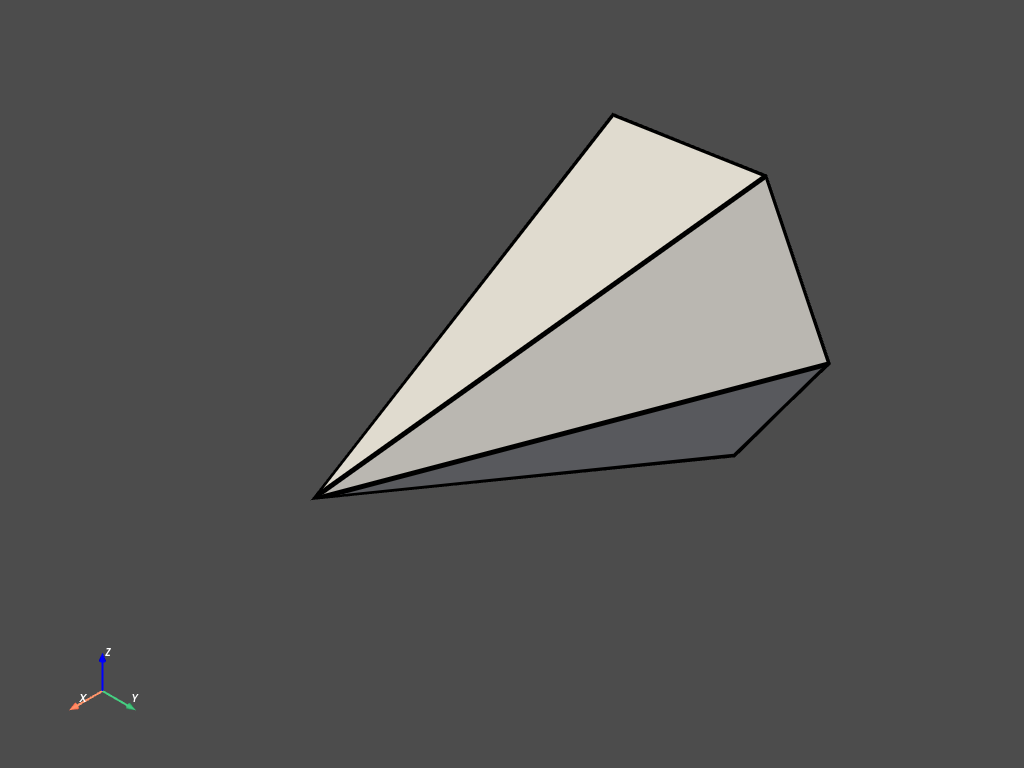

In [13]:
# load a 3D object using PyVista
import pyvista as pv

# mesh = pv.Cone(radius=2, center=[0,0,0], height=5, resolution=3)
mesh = pv.Cone(radius=2, center=[0,0,0], height=5)
# mesh.rotate_y(45, inplace=True)

# mesh = pv.ParametricEllipsoid(10, 5, 5)
# mesh = mesh.decimate_pro(0.75)
# ********* don't try this on Colab ************
mesh.plot(show_edges=True, line_width=5)

In [14]:
tri = mesh.triangulate()
points = np.ascontiguousarray(tri.points)
points

array([[ 2.5000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.5000000e+00,  2.0000000e+00,  0.0000000e+00],
       [-2.5000000e+00,  1.0000000e+00,  1.7320508e+00],
       [-2.5000000e+00, -1.0000000e+00,  1.7320508e+00],
       [-2.5000000e+00, -2.0000000e+00,  2.4492937e-16],
       [-2.5000000e+00, -1.0000000e+00, -1.7320508e+00],
       [-2.5000000e+00,  1.0000000e+00, -1.7320508e+00]], dtype=float32)

In [15]:
tri = mesh.triangulate()
scale_factor = [10.0, 10.0, 10.0]
tri = tri.scale(scale_factor)
points = np.ascontiguousarray(tri.points)
points

C:\Users\dipanjan\Anaconda3\envs\dsenv\lib\site-packages\pyvista\core\pointset.py:261: PyvistaDeprecationWarning: You did not specify a value for `inplace` and the default value will be changing to `False` in future versions for point-based meshes (e.g., `PolyData`). Please make sure you are not assuming this to be an inplace operation.
  warnings.warn(DEFAULT_INPLACE_WARNING, PyvistaDeprecationWarning)


array([[ 2.5000000e+01,  0.0000000e+00,  0.0000000e+00],
       [-2.5000000e+01,  2.0000000e+01,  0.0000000e+00],
       [-2.5000000e+01,  1.0000000e+01,  1.7320507e+01],
       [-2.5000000e+01, -1.0000000e+01,  1.7320507e+01],
       [-2.5000000e+01, -2.0000000e+01,  2.4492936e-15],
       [-2.5000000e+01, -1.0000000e+01, -1.7320507e+01],
       [-2.5000000e+01,  1.0000000e+01, -1.7320507e+01]], dtype=float32)

In [16]:
tri = tri.transform(scene.t_matrix)
points = np.ascontiguousarray(tri.points)
faces = tri.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)
points

array([[75.      , 40.8     , 81.6     ],
       [25.      , 60.8     , 81.6     ],
       [25.      , 50.8     , 98.92051 ],
       [25.      , 30.8     , 98.92051 ],
       [25.      , 20.8     , 81.6     ],
       [25.      , 30.8     , 64.279495],
       [25.      , 50.8     , 64.279495]], dtype=float32)

In [17]:
from LightTransportSimulator.light_transport.src.primitives import Triangle

for v in vertices:
    a,b,c = v[0], v[1], v[2]

    triangle = Triangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                        vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                        vertex_3=np.ascontiguousarray(c, dtype=np.float64),
                        material=PLASTIC)
    triangles.append(triangle)

len(triangles)

10

In [18]:
from LightTransportSimulator.light_transport.src.bvh_new import BoundedBox, BVHNode, build_bvh, LinearBVHNode, flatten_bvh, intersect_bvh

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = []
for i in range(len(triangles)):
    bounded_boxes.append(BoundedBox(triangles[i], i))

len(triangles), len(bounded_boxes)

(10, 10)

In [19]:
if len(triangles)>0:
    # Initialise a bounding volume hierarchy tree
    start = 0
    end = len(bounded_boxes)
    ordered_prims = []
    total_nodes = 0
    root, bounded_boxes, ordered_prims, total_nodes = build_bvh(triangles, bounded_boxes, start, end, ordered_prims, total_nodes)
    # swap the primitives array with the ordered list
    primitives = ordered_prims


    # create a linear representation of the bvh tree
    linear_nodes = numba.typed.List()
    for _ in range(total_nodes):
        linear_nodes.append(LinearBVHNode())


    # linear bvh
    linear_bvh, off_set = flatten_bvh(linear_nodes, root, 0)
    # len(linear_bvh)

    # check if indexes of all primitives present in the linear bvh tree
    total = 0
    for _bvh in linear_bvh:
        total+= _bvh.n_primitives
    print(total==len(triangles)) # should be equal to the number of primitives
else:
    linear_bvh = None
    triangles = None

True


In [20]:
from LightTransportSimulator.light_transport.src.global_illumination import render_scene
# from LightTransportSimulator.light_transport.src.render_old import render_scene

start = time.time()
# primitives = spheres, triangles
image = render_scene(scene, spheres, triangles, linear_bvh)
image = np.flipud(image) # flipped
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\global_illumination.py:149: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)
C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\global_illumination.py:149: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)
C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\global_illumination.py:149: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)


0.050.261780104712045
87.95811518324608
75.3926701570680725.13089005235602337.696335078534034


12.565445026178011
62.82722513089005

25.654450261780106
50.78534031413613
75.91623036649214
88.48167539267016
38.21989528795812
13.089005235602095
63.35078534031414
0.5235602094240838
26.17801047120419
51.30890052356021
76.43979057591623
89.00523560209425
13.61256544502617838.7434554973822

1.0471204188481675
63.87434554973822
26.701570680628272
51.832460732984295
76.96335078534031
14.136125654450261
89.52879581151832
39.26701570680628
1.5706806282722514
64.3979057591623
27.225130890052355
52.35602094240838
77.4869109947644
14.659685863874346
90.05235602094241
39.79057591623037
2.094240837696335
64.92146596858639
27.74869109947644
52.87958115183246
78.01047120418848
15.18324607329843
90.57591623036649
40.31413612565445
28.272251308900522
2.6178010471204187
65.44502617801047
53.403141361256544
78.53403141361257
15.706806282722512
28.79581151832461
91.09947643979058
40.83769633507853
3.141361

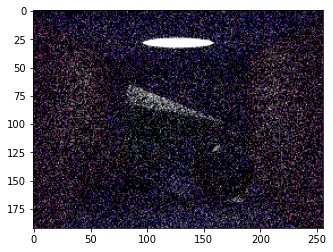

In [21]:
plt.imshow(image)

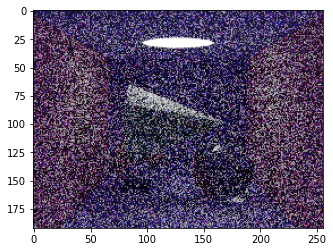

In [22]:
# gamma correction
img_corrected = np.clip(255.0 * np.power(image, 1.0 / 2.2), a_min=0.0, a_max=255.0).astype(int)
plt.imshow(img_corrected)